## Cross-Validation

Having discussed the fundamentals of supervised and unsupervised learning, and having explored a variety of machine learning algorithms, we will now dive more deeply into evaluating models and selecting parameters.

We will focus on the supervised methods, regression and classification, as evaluating and selecting models in unsupervised learning is often a very qualitative process.

To evaluate our supervised models, so far we have split our dataset into a training set and a test set using the *train_test_split* function, built a model on the training set by calling the *fit* method, and evaluated it on the test set using the *score* method, which for classification computes the fraction of correctly classified samples. Here’s an example of that process:

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Create a synthetic dataset
X, y = make_blobs(random_state=0)

# Split data and labels into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Instantiate a model and fit it to the training set
logreg = LogisticRegression().fit(X_train, y_train)

# Evaluate the model on the test set
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


Remember, the reason we split our data into training and test sets is that we are interested in measuring how well our model generalizes to new, previously unseen data. We are not interested in how well our model fit the training set, but rather in how well it can make predictions for data that was not observed during training.

In this chapter, we will expand on two aspects of this evaluation. We will first introduce *cross-validation*, a more robust way to assess generalization performance, and discuss methods to evaluate classification and regression performance that go beyond the default measures of accuracy and R2 provided by the score method.

We will also discuss *grid search*, an effective method for adjusting the parameters in supervised models for the best generalization performance. 

### Cross-Validation

*Cross-validation* is a statistical method of evaluating generalization performance that is more stable and thorough than using a split into a training and a test set. In cross-validation, the data is instead split repeatedly and multiple models are trained. 

The most commonly used version of cross-validation is *k-fold cross-validation*, where k is a user-specified number, usually 5 or 10. When performing five-fold cross-validation, the data is first partitioned into five parts of (approximately) equal size, called *folds*. 

Next, a sequence of models is trained. The first model is trained using the first fold as the test set, and the remaining folds (2–5) are used as the training set. The model is built using the data in folds 2–5, and then the accuracy is evaluated on fold 1. Then another model is built, this time using fold 2 as the test set and the data in folds 1, 3, 4, and 5 as the training set. This process is repeated using folds 3, 4, and 5 as test sets. For each of these five splits of the data into training and test sets, we compute the accuracy. In the end, we have collected five accuracy values. 

The process is illustrated here:

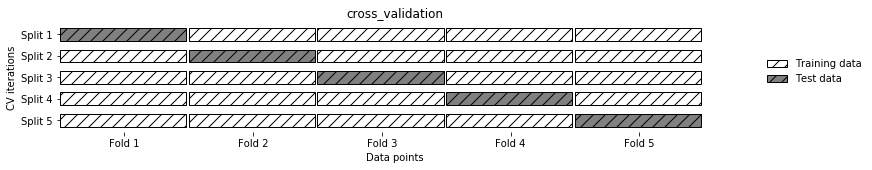

In [4]:
mglearn.plots.plot_cross_validation()

Usually, the first fifth of the data is the first fold, the second fifth of the data is the second fold, and so on.

### Cross-Validation in scikit-learn

Cross-validation is implemented in *scikit-learn* using the *cross_val_score* function from the *model_selection* module. The parameters of the *cross_val_score* function are the model we want to evaluate, the training data, and the ground-truth labels. Let’s evaluate *LogisticRegression* on the *iris* dataset:

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.96078431 0.92156863 0.95833333]


Here, *cross_val_score* performed three-fold cross-validation and therefore returned three scores. By default, *cross_val_score* performs three-fold cross-validation in earlier versions of scikit-learn, and will perform five-fold cross-validation by default (starting with scikit-learn 0.22). We can change the number of folds used by changing the *cv* parameter:

In [6]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.         0.96666667 0.93333333 0.9        1.        ]


It’s recommended to use at least five-fold cross-validation. A common way to summarize the cross-validation accuracy is to compute the mean:

In [7]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


Using the mean cross-validation we can conclude that we expect the model to be around 96% accurate on average. Looking at all five scores produced by the five-fold cross-validation, we can also conclude that there is a relatively high variance in the accuracy between folds, ranging from 100% accuracy to 90% accuracy. This could imply that the model is very dependent on the particular folds used for training, but it could also just be a consequence of the small size of the dataset. 

There is a second function you can use for cross-validation, called *cross_validate*. It has a similar interface to *cross_val_score*, but returns a dictionary containing training and test times (and optionally the training score, in addition to the test scores) for each split:

In [8]:
from sklearn.model_selection import cross_validate

res = cross_validate(logreg, iris.data, iris.target, cv=5, return_train_score=True)
display(res)

{'fit_time': array([0.00177312, 0.00174832, 0.00123787, 0.00122571, 0.00121379]),
 'score_time': array([0.00057912, 0.00043249, 0.00042343, 0.00039077, 0.00038838]),
 'test_score': array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 'train_score': array([0.95      , 0.96666667, 0.96666667, 0.975     , 0.95833333])}

Using pandas, we can nicely display these results and compute summaries:

In [9]:
res_df = pd.DataFrame(res)
display(res_df)

print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.001773,0.000579,1.000000,0.950000
1,0.001748,0.000432,0.966667,0.966667
2,0.001238,0.000423,0.933333,0.966667
3,0.001226,0.000391,0.900000,0.975000
4,0.001214,0.000388,1.000000,0.958333


Mean times and scores:
 fit_time       0.001440
score_time     0.000443
test_score     0.960000
train_score    0.963333
dtype: float64


### Benefits of Cross-Validation

There are several benefits to using cross-validation instead of a single split into a training and a test set. First, remember that *train_test_split* performs a random split of the data. Imagine that we are “lucky” when randomly splitting the data, and all examples that are hard to classify end up in the training set. In that case, the test set will only contain “easy” examples, and our test set accuracy will be unrealistically high. Conversely, if we are “unlucky,” we might have randomly put all the hard-to-classify examples in the test set and consequently obtain an unrealistically low score. However, when using cross-validation, each example will be in the test set exactly once: each example is in one of the folds, and each fold is the test set once. Therefore, the model needs to generalize well to all of the samples in the dataset for all of the cross-validation scores (and their mean) to be high.

Having multiple splits of the data also provides some information about how sensitive our model is to the selection of the training dataset. For the *iris* dataset, we saw accuracies between 90% and 100%. This is quite a range, and it provides us with an idea about how the model might perform in the worst case and best case scenarios when applied to new data.

Another benefit of cross-validation as compared to using a single split of the data is that we use our data more effectively. When using train_test_split, we usually use 75% of the data for training and 25% of the data for evaluation. When using five-fold cross-validation, in each iteration we can use four-fifths of the data (80%) to fit the model. When using 10-fold cross-validation, we can use nine-tenths of the data (90%) to fit the model. More data will usually result in more accurate models.

The main disadvantage of cross-validation is increased computational cost. As we are now training k models instead of a single model, cross-validation will be roughly k times slower than doing a single split of the data.

Note that it is important to keep in mind that cross-validation is not a way to build a model that can be applied to new data. Cross-validation does not return a model. When calling *cross_val_score*, multiple models are built internally, but the purpose of cross-validation is only to evaluate how well a given algorithm will generalize when trained on a specific dataset.